<a href="https://colab.research.google.com/github/mneedham/link-prediction/blob/master/02_LinkPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Coding Challenge

In this notebook we're going to do link prediction on an authors and papers graph. We'll be trying to work out which authors are likely to collaborate in future.

In [ ]:
! pip install sklearn matplotlib neo4j pandas

In [90]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from neo4j import GraphDatabase
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [2]:
driver = GraphDatabase.driver("bolt://localhost", auth=("neo4j", "neo"))

## Exploring the data

In this section we're going to explore the data and see what we have to work with.

In [3]:
query = """
MATCH (article:Article)
RETURN article.year AS year, count(*) AS count
ORDER BY year
"""

with driver.session() as session:
    result = session.run(query)
    by_year = pd.DataFrame([dict(record) for record in result])
by_year.head()    

,count,year
0,19,1958
1,42,1959
2,53,1960
3,166,1961
4,201,1962


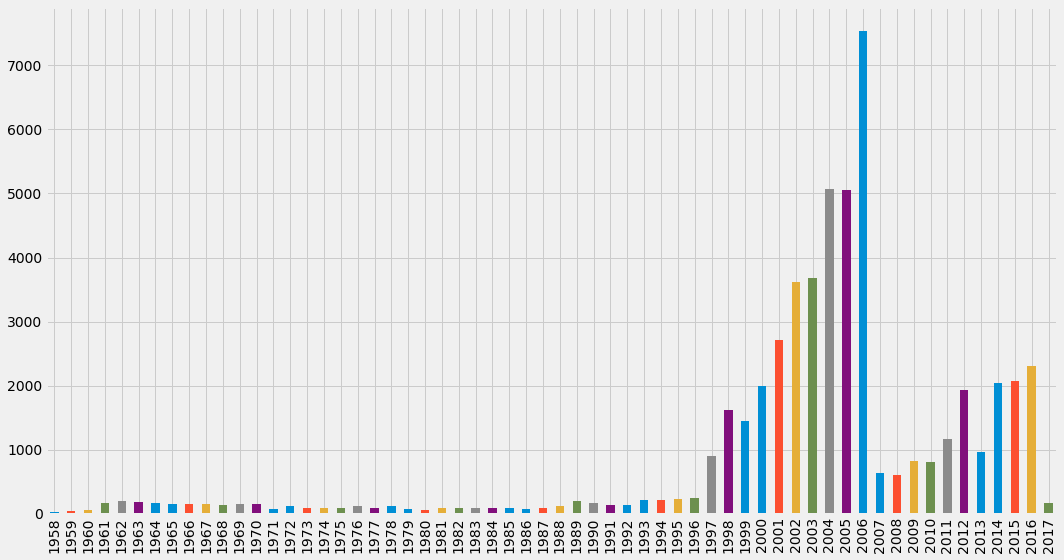

In [4]:
plt.style.use('fivethirtyeight')
ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

## Splitting the train and test data

In this section we're going to split our data into training and test sets to use with a machine learning classifier. 


In [ ]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
WHERE year < 2006
MERGE (a1)-[coauthor:CO_AUTHOR_EARLY {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""

with driver.session() as session:
    session.run(query)

In [ ]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
WHERE year >= 2006
MERGE (a1)-[coauthor:CO_AUTHOR_LATE {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""

with driver.session() as session:
    session.run(query)

In [23]:
def as_data_frame(driver, query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([dict(record) for record in result])

In [24]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

count_df = as_data_frame(driver, query)
count_df

,count
0,81096


In [13]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

count_df = as_data_frame(driver, query)
count_df

,count
0,74128


In [10]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [15]:
train_existing_links = as_data_frame(driver, """
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""")

train_missing_links = as_data_frame(driver, """
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""")

train_missing_links = train_missing_links.drop_duplicates()
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [76]:
test_existing_links = as_data_frame(driver, """
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""")

test_missing_links = as_data_frame(driver, """
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""")

test_missing_links = test_missing_links.drop_duplicates()
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

## Choosing a machine learning algorithm

In [21]:
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

## Generating graphy features

In [73]:
def apply_graphy_training_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           size([(p1)-[:CO_AUTHOR_EARLY]-(a)-[:CO_AUTHOR_EARLY]-(p2) | a]) AS commonAuthors,
           size((p1)-[:CO_AUTHOR_EARLY]-()) * size((p2)-[:CO_AUTHOR_EARLY]-()) AS prefAttachment,
           size(apoc.coll.toSet([
            (p1)-[:CO_AUTHOR_EARLY]->(a) | id(a)] + [(p2)-[:CO_AUTHOR_EARLY]->(a) | id(a)
           ])) AS totalNeighbours
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = as_data_frame(driver, query, {"pairs": pairs})
    return pd.merge(data, features, on = ["node1", "node2"])

def apply_graphy_test_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           size([(p1)-[:CO_AUTHOR]-(a)-[:CO_AUTHOR]-(p2) | a]) AS commonAuthors,
           size((p1)-[:CO_AUTHOR]-()) * size((p2)-[:CO_AUTHOR]-()) AS prefAttachment,
           size(apoc.coll.toSet([
            (p1)-[:CO_AUTHOR]->(a) | id(a)] + [(p2)-[:CO_AUTHOR]->(a) | id(a)
           ])) AS totalNeighbours
    """
    pairs = [{"node1": node1, "node2": node2} for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = as_data_frame(driver, query, {"pairs": pairs})
    return pd.merge(data, features, on = ["node1", "node2"])

In [60]:
training_df = apply_graphy_training_features(training_df)

162192 162192


In [61]:
training_df.head()

,label,node1,node2,commonAuthors,prefAttachment,totalNeighbours
0,1,30055,30056,1,4,1
1,0,78610,71760,0,12,6
2,1,30004,52634,11,180,12
3,0,118990,13839,0,72,11
4,0,43099,51435,0,8,1


In [77]:
test_df = apply_graphy_test_features(test_df)

In [79]:
test_df.head()

148256

## Evaluating results

In [114]:
columns = ["commonAuthors"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

list(zip(columns, classifier.feature_importances_))

'Accuracy'

0.8644574249946039

'Precision'

0.9686703096539162

'Recall'

0.7532781135333477

[('commonAuthors', 1.0)]

In [115]:
columns = ["commonAuthors", "prefAttachment", "totalNeighbours"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

list(zip(columns, classifier.feature_importances_))

'Accuracy'

0.9338711418087632

'Precision'

0.9529476382277554

'Recall'

0.9128129721562702

[('commonAuthors', 0.7307980031969826),
 ('prefAttachment', 0.18430777735126466),
 ('totalNeighbours', 0.08489421945175285)]